In [1]:
import sys
sys.path.append(r'C:\Users\USER\Documents\GitHub\frft')
sys.path.append(r'C:\Users\USER\Documents\GitHub\DLOCT\Analysis_cGAN')
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq, fftshift, ifft
import sys
from tqdm import tqdm # for progress bars
from statistics import mean, stdev
from scipy.signal import find_peaks
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import plotly.express as px
# Repositorio
sys.path.append(r'C:\Users\USER\Documents\GitHub\frft') 
import torch
import frft
import frft_gpu as frft_g
import time
from Deep_Utils import dbscale


def extract_dimensions(file_name):
    parts = file_name.split('_')
    dimensions = []
    for part in parts:
        if 'z=' in part or 'x=' in part or 'y=' in part:
            number = int(part.split('=')[-1])
            dimensions.append(number)
    return tuple(dimensions)

def read_tomogram(file_path, dimensions):
    depth, height, width = dimensions
    with open(file_path, 'rb') as file:
        tomogram = np.fromfile(file, dtype='single')
        tomogram = tomogram.reshape((depth, height, width),order='F')
    return tomogram

In [2]:
pathcomplex = r'C:\Users\USER\Documents\GitHub\[s.fovea]11bscan'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
        real_file_path = os.path.join(pathcomplex, real_file)
        imag_file_path = os.path.join(pathcomplex, imag_file)
        dimensions = extract_dimensions(real_file[:-4])
        tomReal = read_tomogram(real_file_path, dimensions)
        tomImag = read_tomogram(imag_file_path, dimensions)
        tomcc = tomReal + 1j * tomImag
        del tomImag, tomReal
# fringescc = fftshift(ifft(fftshift(tom,axes=0),axis=0),axes=0)
fringescc = fftshift(ifft(tomcc,axis=0),axes=0)

pathcomplex = r'C:\Users\USER\Documents\GitHub\[s.fovea]11bscanNoartifacts'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
        real_file_path = os.path.join(pathcomplex, real_file)
        imag_file_path = os.path.join(pathcomplex, imag_file)
        dimensions = extract_dimensions(real_file[:-4])
        tomReal = read_tomogram(real_file_path, dimensions)
        tomImag = read_tomogram(imag_file_path, dimensions)
        tom = tomReal + 1j * tomImag
        del tomImag, tomReal
# fringescc = fftshift(ifft(fftshift(tom,axes=0),axis=0),axes=0)
fringes = fftshift(ifft(tom,axis=0),axes=0)

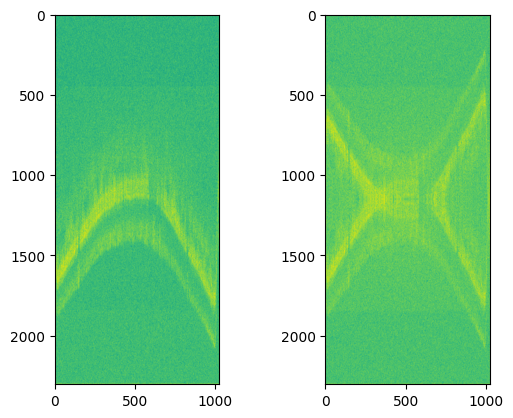

In [3]:
fig,axs = plt.subplots(nrows=1,ncols=2)
axs[0].imshow(dbscale(tom[:,:,0]))
axs[1].imshow(dbscale(tomcc[:,:,0]))

In [4]:
fs = int(2304/8)
srvfreq = np.fft.fftshift(np.fft.fftfreq(len(tom), 1/fs))


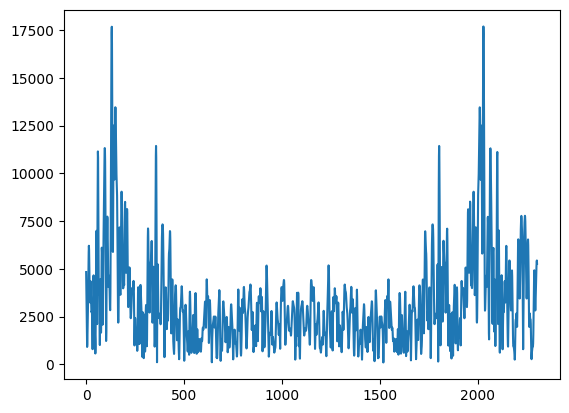

In [6]:
f1 = 100e9 # Primera frecuencia
w1 = 2*np.pi*f1
phase1 = np.pi/2
t = np.linspace(0,1,len(tom))
modulator = np.exp(1j*(w1*t+phase1))
modulated_fringes = modulator*fringescc[:,0,0]
modulated_fft = fftshift(fft(modulated_fringes))
plt.plot(abs(modulated_fft))

In [7]:
fig = make_subplots(rows=3, cols=1)
fig.add_trace(
    go.Scatter(y=np.real(tomcc[:,0,0]), mode='lines', name='artifacts fringes'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(y=np.real(tom[:,0,0]), mode='lines', name='no artifacts real part'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=np.imag(tom[:,0,0]), mode='lines', name='no artifacts image part'),
    row=3, col=1
)
fig.update_layout(
    title_text="Análisis de Señales",
    height=900,  # Ajusta la altura si es necesario
    showlegend=False
)
fig.update_xaxes(title_text="artifacts fringes", row=1, col=1)
fig.update_xaxes(title_text="no artifacts real part", row=2, col=1)
fig.update_xaxes(title_text="no artifacts image part", row=3, col=1)

fig.show()

In [8]:

nSnapshots = 500 #fs
alpha = np.linspace( 0., 2.,nSnapshots)
obj_1d_shifted_gpu = torch.from_numpy(np.real(fringescc[:,0,0])).cuda()
results = []
gputime = []
for al in tqdm( alpha, total=alpha.size ):
    start = time.time()
    fobj_1d = frft_g.frft( obj_1d_shifted_gpu, al )
    results.append( fftshift(torch.Tensor.numpy(torch.Tensor.cpu(fobj_1d))))
    t_gpu = time.time() - start
    gputime.append( t_gpu*1.e6 )
print( 'Mean GPU time = %f μs'%mean( gputime ) )
frftarray = (np.array(results))
phasefrft = np.angle(frftarray)
unwrapped_phase = abs(np.unwrap(phasefrft))

100%|██████████| 500/500 [00:01<00:00, 340.71it/s]


Mean GPU time = 2893.589497 μs


In [9]:
middle = int(nSnapshots/2)
px.line(y=abs(fftshift(frftarray[middle])))

In [10]:
frft_mean = frftarray.mean(axis=0)
frft_std = frftarray.std(axis=0)
phase_mean = phasefrft.mean(axis=0)
phase_std = phasefrft.std(axis=0)
unwrapped_mean = unwrapped_phase.mean(axis=0)
unwrapped_std = unwrapped_phase.std(axis=0)

fig = make_subplots(rows=4, cols=1)
# fig.add_trace(
#     go.Scatter(x =srvfreq ,y=np.abs(frft_mean), mode='lines', name='mean frft amplitude '),
#     row=1, col=1
# )
fig.add_trace(
    go.Scatter(x =srvfreq ,y=np.abs(fftshift(frft_mean-frft_std)), mode='lines', name='mean frft amplitude '),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x = srvfreq,y=np.abs(tom[:,0,0]), mode='lines', name='target signal'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x = srvfreq,y=np.abs(tomcc[:,0,0]), mode='lines', name='target signal'),
    row=3, col=1
)
# fig.add_trace(
#     go.Scatter(x= srvfreq, y=unwrapped_mean-unwrapped_std, mode='lines', name='mean phase frft'),
#     row=4, col=1
# )

fig.add_trace(
    go.Scatter(x= srvfreq, y=unwrapped_mean, mode='lines', name='std phase frft'),
    row=4, col=1
)

fig.update_layout(
    title_text="Análisis de Señales",
    height=900,  # Ajusta la altura si es necesario
    showlegend=False
)
fig.update_xaxes(title_text="mean frft amplitude", row=1, col=1)
fig.update_xaxes(title_text="target signal", row=2, col=1)
fig.update_xaxes(title_text="complex conjugate artifacts", row=3, col=1)
fig.update_xaxes(title_text="mean phase frft", row=4, col=1)
fig.show()

In [11]:
frecuency = int(nSnapshots/2)
fig = make_subplots(rows=4, cols=1)
fig.add_trace(
    go.Scatter(x = srvfreq,y=np.real(fftshift(frftarray[frecuency])), mode='lines', name='target signal'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x = srvfreq,y=np.imag(fftshift(frftarray[frecuency])), mode='lines', name='target signal'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x = srvfreq,y=abs(tom[:,0,0]), mode='lines', name='target signal'),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x = srvfreq,y=abs(fftshift(frftarray[frecuency])), mode='lines', name='target signal'),
    row=4, col=1
)

fig.update_layout(
    title_text="Análisis de Señales",
    height=900,  # Ajusta la altura si es necesario
    showlegend=False
)
fig.update_xaxes(title_text="real part", row=1, col=1)
fig.update_xaxes(title_text="image part", row=2, col=1)

fig.show()

In [12]:
frecuency = 0
fig = make_subplots(rows=4, cols=1)
fig.add_trace(
    go.Scatter(x = srvfreq,y=np.real(fftshift(frftarray[frecuency])), mode='lines', name='target signal'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x = srvfreq,y=np.imag(fftshift(frftarray[frecuency])), mode='lines', name='target signal'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x = srvfreq,y=np.real(fringes[:,0,0]), mode='lines', name='target signal'),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x = srvfreq,y=np.imag(fringes[:,0,0]), mode='lines', name='target signal'),
    row=4, col=1
)

fig.update_layout(
    title_text="Análisis de Señales",
    height=900,  # Ajusta la altura si es necesario
    showlegend=False
)
fig.update_xaxes(title_text="real part frft", row=1, col=1)
fig.update_xaxes(title_text="image part frft", row=2, col=1)
fig.update_xaxes(title_text="real part complex fringes", row=3, col=1)
fig.update_xaxes(title_text="image part complex fringes", row=4, col=1)
fig.show()